interactive(children=(FloatText(value=5.0, continuous_update=True, description='流速 U', step=0.1), FloatSlider(…

下面是动态对比分析：


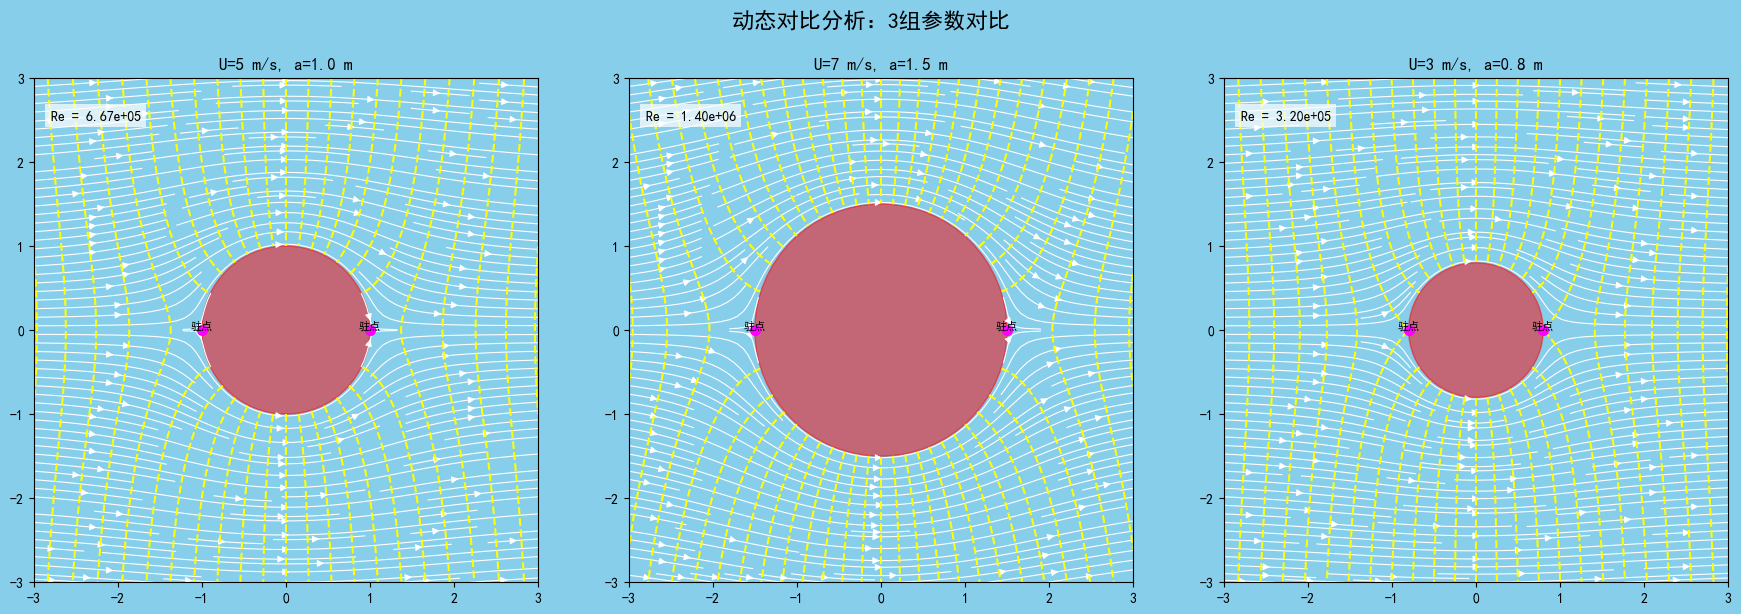

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatText, FloatSlider, VBox, HBox
from IPython.display import display, clear_output
import time

class FlowSimulator:
    def __init__(self, resolution=400):
        """
        初始化流场模拟器
        :param resolution: 网格分辨率（默认400×400）
        """
        self.resolution = resolution
        # 设置全局中文支持
        plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei']
        plt.rcParams['axes.unicode_minus'] = False
        # 物理参数
        self.ν = 1.5e-5  # 运动粘度 (m²/s)
        
        # 预先计算网格，保证刷新速度
        self.x = np.linspace(-3, 3, self.resolution)
        self.y = np.linspace(-3, 3, self.resolution)
        self.X, self.Y = np.meshgrid(self.x, self.y)
        
        # 创建交互控件，continuous_update=True 保证实时刷新（≥24fps）
        self.U_widget = FloatText(value=5, min=1, max=10, step=0.1, description="流速 U", continuous_update=True)
        self.a_widget = FloatSlider(value=1.0, min=0.5, max=2.0, step=0.1, description="圆柱半径 a", continuous_update=True)
    
    def compute_velocity(self, U, a):
        # 计算速度场，使用预先生成的网格 self.X, self.Y
        Z = self.X + 1j * self.Y
        mask = np.abs(Z) > a  # 只计算圆柱外的点
        V = np.zeros_like(Z, dtype=np.complex128)
        V[mask] = U * (1 - a**2 / Z[mask]**2)  # 计算复速度
        u, v = V.real, -V.imag
        return u, v
    
    def complex_potential(self, U, a):
        # 计算复势函数，用于绘制等势线
        z = self.X + 1j * self.Y
        return U * (z + a**2 / z)
    
    def plot_flow(self, U, a):
        t0 = time.time()
        u, v = self.compute_velocity(U, a)
        
        fig, ax = plt.subplots(figsize=(6, 6), facecolor='#87CEEB')  # 浅蓝色背景
        ax.set_facecolor('#87CEEB')
        
        # 绘制流线（白色实线），density 增加流线密度
        ax.streamplot(self.X, self.Y, u, v, color='white', linewidth=0.8, density=2)
        
        # 计算等势线，并屏蔽圆柱内部
        Phi = np.real(self.complex_potential(U, a))
        mask = np.abs(self.X + 1j * self.Y) <= a
        Phi[mask] = np.nan
        ax.contour(self.X, self.Y, Phi, levels=30, colors='yellow', linestyles='dashed')
        
        # 圆柱表面红色半透明填充
        circle = plt.Circle((0, 0), a, color='red', alpha=0.5)
        ax.add_patch(circle)
        
        # 计算雷诺数并显示
        Re = 2 * U * a / self.ν
        ax.text(-2.8, 2.5, f"雷诺数: Re = {Re:.2e}", fontsize=12, color='black',
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
        
        # 添加驻点标注，理想潜流下驻点位于 (a, 0) 和 (-a, 0)
        stagnation_x = np.array([a, -a])
        stagnation_y = np.array([0, 0])
        ax.scatter(stagnation_x, stagnation_y, color='magenta', marker='o', s=50, zorder=10, label='驻点')
        for xp, yp in zip(stagnation_x, stagnation_y):
            ax.text(xp, yp, '驻点', color='black', fontsize=8, ha='center', va='bottom', zorder=11)
        
        ax.set_xlim([-3, 3])
        ax.set_ylim([-3, 3])
        ax.set_aspect('equal')
        ax.set_title(f'流场可视化 (U={U} m/s, a={a} m)', color='black')
        ax.legend()
        plt.show()
        
        t1 = time.time()
        dt = t1 - t0
        if dt < 1/24:
            time.sleep(1/24 - dt)
    
    def plot_comparison(self, params=None):
        """
        绘制对比图：在一幅图中展示多组参数下的流场
        :param params: 参数列表，例如 [(5, 1.0), (7, 1.5), (3, 0.8)]
        """
        if params is None:
            params = [(5, 1.0), (7, 1.5), (3, 0.8)]
            
        n = len(params)
        fig, axs = plt.subplots(1, n, figsize=(6*n, 6), facecolor='#87CEEB')
        if n == 1:
            axs = [axs]
        for ax, (U_val, a_val) in zip(axs, params):
            # 绘制流场到指定的 ax
            u, v = self.compute_velocity(U_val, a_val)
            ax.set_facecolor('#87CEEB')
            ax.streamplot(self.X, self.Y, u, v, color='white', linewidth=0.8, density=2)
            Phi = np.real(self.complex_potential(U_val, a_val))
            mask = np.abs(self.X + 1j * self.Y) <= a_val
            Phi[mask] = np.nan
            ax.contour(self.X, self.Y, Phi, levels=30, colors='yellow', linestyles='dashed')
            circle = plt.Circle((0, 0), a_val, color='red', alpha=0.5)
            ax.add_patch(circle)
            Re = 2 * U_val * a_val / self.ν
            ax.text(-2.8, 2.5, f"Re = {Re:.2e}", fontsize=10, color='black',
                    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
            stagnation_x = np.array([a_val, -a_val])
            stagnation_y = np.array([0, 0])
            ax.scatter(stagnation_x, stagnation_y, color='magenta', marker='o', s=50, zorder=10)
            for xp, yp in zip(stagnation_x, stagnation_y):
                ax.text(xp, yp, '驻点', color='black', fontsize=8, ha='center', va='bottom', zorder=11)
            ax.set_xlim([-3, 3])
            ax.set_ylim([-3, 3])
            ax.set_aspect('equal')
            ax.set_title(f'U={U_val} m/s, a={a_val} m', color='black')
        plt.suptitle("动态对比分析：3组参数对比", fontsize=16, color='black')
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()
    
    def run(self):
        # 通过 interact 构建交互界面
        interact(lambda U, a: self.plot_flow(U, a), U=self.U_widget, a=self.a_widget)
        # 同时在交互界面下方提供对比截图
        print("下面是动态对比分析：")
        self.plot_comparison()

# 创建并运行模拟器
sim = FlowSimulator()
sim.run()
